<img src="https://cdn.vox-cdn.com/thumbor/Z9YA9yAEq8x3-NL660dkqQxNPAM=/0x0:1980x1320/1200x800/filters:focal(832x502:1148x818)/cdn.vox-cdn.com/uploads/chorus_image/image/59943837/microsoftgithublove.0.jpg" alt="mcrsft" class="bg-primary mb-1" width="500px" align="right">

# NLP Modeling - Team Project
### Using data from Microsoft's GitHub Page

By:
- Jason Tellez
- Jeff Akins
- Veronica Reyes
- Jacob Paxton

## Project Goal
The goal of this project was to build a model that can predict the primary programming language for a GitHub repository, given the text of the README file. To achieve this, we first had to decide which and how many repos we wanted to acquire. Microsoft has a large number of repos on its GitHub site with a wide variety of coding languages, so we determined that we could extract a sufficient number of README and coding languages from their repos. This required the use of a variety of web scraping and Natural Language Processing tools as well as use of GitHub's API. In the end we acquired 1500 READMEs along with their associated primary coding language from Microsoft's GitHub page. The results are contained in this notebook as well as in a presentation slide deck.


## Executive Summary
After acquiring and exploring the READMEs that we collected, we determined that the most common coding language in Microsoft's repos was TypeScript. Therefore, we decided to use classification modeling to attempt to predict whether a Microsoft repo used TypeScript based on select features from the READMEs. Ultimately, we were able to predict with an 84% accuracy whether a repo used TypeScript, which was a 10% improvement over the baseline. Below are the details on how we achieved this.

### How to Recreate:
There are two methods that you can use to recreate this project.
1. **Quick Method:** Utilize our final .json file with the cleaned README files. This is the simplest method and will produce the same results that we were able to achieve.
2. **Long Method:** Start from scratch using the same functions that we used. This will pull in the most recent repos from Microsoft's GitHub page and therefore will produce slightly different results from what we achieved. This method will also take longer e.g. it took us nearly 30 minutes to download the data from the 1500 repos. 

##### Imports

In [1]:
# For websraping and NLP
import requests
from bs4 import BeautifulSoup
from typing import Dict, List, Optional, Union, cast

# For Timestamps
import time
from time import strftime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

import json
import wrangle as wr
import model

from wordcloud import WordCloud, ImageColorGenerator, get_single_color_func

import warnings
warnings.filterwarnings("ignore")

# Follow the instructions on the acquire file for creating your env file if needed
#from env import github_token, github_username

## Acquire

##### Using the Quick Method:
1. Download this [file](https://drive.google.com/file/d/1aec5UqivmWouJ0DqFM-3Nn3yE1Bd-E7f/view)
2. Save the file to the same folder as this notebook. 
3. Run the next cell.

In [2]:
df = pd.read_json('cleaned_readmes.json')

##### Using the Long Method
1. Make a env file with a github personal access token.
    - Go here and generate a personal access [token](https://github.com/settings/tokens)
    - You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
    - Save it in your env.py file under the variable `github_token`
    - Add your github username to your env.py file under the variable `github_username`
2. Uncomment and run the functions and follow the instructions in the below cell:

In [3]:
# long method:
# df = wr.get_repo_links()
# df.to_csv('microsoft_repo_list.csv')
# -- Run the aquire.py file in your terminal using: python acquire.py
# -- Once it is finished, run the next function to clean the data:
# df = wr.wrangle()

## Preparation
The following steps were taken to clean our data:
1. Dropped rows with null values in the 'language' column
2. Reset the index index
3. Created a series consisting of normalized string values and combined the series with the dataframe
4. Created normalized, lemmatized strings with no stopwords from the 'clean' column
5. Dropped rows that had null values in the 'content' columns and reset the index
6. Created a word count and a character count column 
7. Created a target column that shows whether repo language is TypeScript or not
8. Dropped the original readme contents column

This created the following results:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 0 to 1369
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   repo                1370 non-null   object
 1   language            1370 non-null   object
 2   clean               1370 non-null   object
 3   lemma_no_stopwords  1370 non-null   object
 4   clean_word_count    1370 non-null   int64 
 5   readme_char_count   1370 non-null   int64 
 6   is_TypeScript       1370 non-null   bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 76.3+ KB


In [5]:
df.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript
0,microsoft/react-native-windows,C++,react native for windows build native windows ...,react native window native window apps react h...,536,4288,False
1,microsoft/fast,TypeScript,fastbannergithub914pnghttpsstaticfastdesignass...,fastbannergithub914pnghttpsstaticfastdesignass...,981,8539,True
2,microsoft/Application-Insights-Workbooks,JSON,azure monitor workbook templates build statush...,azure monitor workbook template statushttpsgit...,385,3411,False
3,microsoft/gctoolkit,Java,microsoft gctoolkit gctoolkit is a set of libr...,microsoft gctoolkit gctoolkit set library anal...,349,2815,False
4,microsoft/winget-cli-restsource,C#,welcome to the wingetclirestsource repository ...,welcome wingetclirestsource repository buildin...,780,5557,False


## Exploration 

In [6]:
#Take a look at the data that was acquired and prepped
df.shape

(1370, 7)

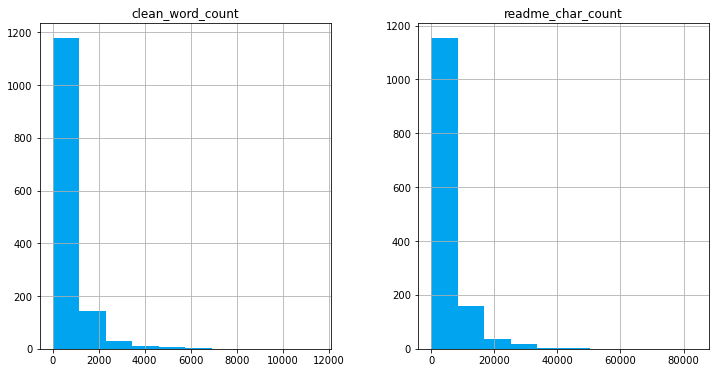

In [104]:
#Take a look at the histogram of numerical variables
df.hist(figsize=(12,6), color=('#00a4ef'))
plt.show()

In [8]:
#Confirm data does not contain nulls
df.isna().sum()

repo                  0
language              0
clean                 0
lemma_no_stopwords    0
clean_word_count      0
readme_char_count     0
is_TypeScript         0
dtype: int64

##### Before exploring further, we will split the data into train, validate and test datasets.

In [9]:
#Call the train_val_test_split function from wrangle.py

train, validate, test = wr.train_val_test_split(df, random_state=123)

In [10]:
#Look at the shape of each dataset created

train.shape, validate.shape, test.shape

((876, 7), (220, 7), (274, 7))

### Q.) Do different programming languages use a different number of unique words?

In [11]:
#Take a look at the count and percentage of words 
languages = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

,n,percent
TypeScript,225,0.256849
C#,146,0.166667
Python,118,0.134703
C++,70,0.079909
JavaScript,65,0.074201
PowerShell,48,0.054795
C,32,0.036530
Jupyter Notebook,28,0.031963
HTML,21,0.023973
Java,19,0.021689


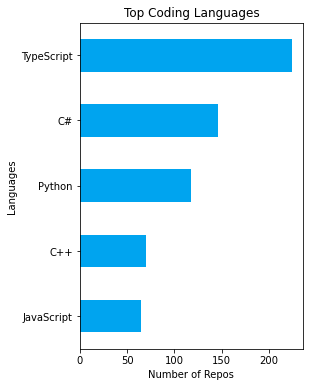

In [154]:
plt.figure(figsize=(4,6))

languages.n.sort_values(ascending=True).tail().plot.barh(color='#00a4ef')
plt.title('Top Coding Languages')
plt.xlabel('Number of Repos')
plt.ylabel('Languages')
plt.show()

#### It looks like TypeScript is the most common type of programming language used making up 25% of the the repos acquired. 
 - We will make TypeScript the target programming language to predict.

#### Categorize words associated to TypeScript repos vs those that are not TypeScript repos to run comparisons against. 

In [12]:
#TypeScript words
TS_words = ' '.join(train[train.language == 'TypeScript'].lemma_no_stopwords.astype('str')).split()

#Non-TypeScript words
NTS_words = ' '.join(train[train.language != 'TypeScript'].lemma_no_stopwords.astype('str')).split()

#All words combined
all_words = ' '.join(train.lemma_no_stopwords.astype('str')).split()

In [13]:
#Get respective frequency counts

TS_freq = pd.Series(TS_words).value_counts()
NTS_freq = pd.Series(NTS_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [14]:
#Look at top 5 most frequently occuring words for all repos
all_freq.head()

project      3202
microsoft    2814
run          2171
9            1885
azure        1875
dtype: int64

In [15]:
#Look at top 5 most frequently occuring words for TypeScript repos
TS_freq.head()

9            1303
project       801
run           695
microsoft     598
extension     538
dtype: int64

In [16]:
#Look at top 5 most frequently occuring words for Non-TypeScript repos
NTS_freq.head()

project      2401
microsoft    2216
azure        1489
run          1476
data         1463
dtype: int64

- The most common words in READMEs for ALL repos are:

    - project      
    - microsoft    
    - run          
    - 9            
    - azure 

- The most common words in READMEs for TypeScript repos are:

    - 9            
    - project      
    - run          
    - microsoft    
    - extension  
    
- The most common words in READMEs for Non-TypeScript repos are:

    - project      
    - microsoft    
    - azure        
    - run          
    - data          

In [17]:
#Look at ratio of word counts
word_counts = (pd.concat([all_freq, TS_freq, NTS_freq], axis=1, sort=True)
                .set_axis(['all', 'TS', 'NTS'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,TS,NTS
0,398,127,271
00,74,1,73
000,17,0,17
0000,5,0,5
000000,2,0,2


In [18]:
#Look at the ratio between the words

(word_counts
 [(word_counts.NTS > 10) & (word_counts.TS > 10)]
 .assign(ratio=lambda df: df.NTS / (df.TS + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,TS,NTS,ratio
chart,151,124,27,0.217724
typescript,211,171,40,0.233904
survey,57,46,11,0.239078
intellisense,56,45,11,0.244390
k,60,47,13,0.276537
python,707,48,659,13.726307
linux,459,30,429,14.295235
learning,383,19,364,19.147817
model,1318,59,1259,21.335367
powershell,367,12,355,29.558701


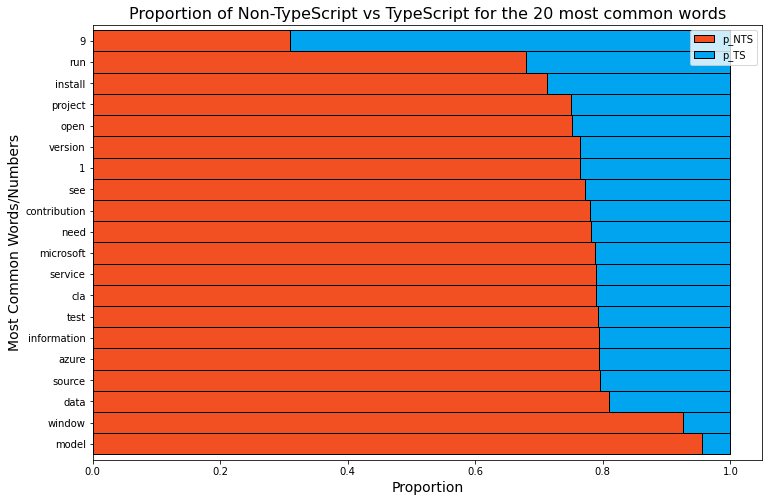

In [99]:
### Visualize 

# figure out the percentage
(word_counts
 .assign(p_NTS=word_counts.NTS / word_counts['all'],
         p_TS=word_counts.TS / word_counts['all'])
 .sort_values(by='all')
 [['p_NTS', 'p_TS']]
 .tail(20)
 .sort_values('p_TS')
 .plot.barh(stacked=True, width = 1, ec = 'k',color=['#f25022', '#00a4ef'], figsize = (12, 8)))

plt.title('Proportion of Non-TypeScript vs TypeScript for the 20 most common words', fontsize=16)
plt.xlabel('Proportion', fontsize=14)
plt.ylabel('Most Common Words/Numbers', fontsize=14)
plt.show()

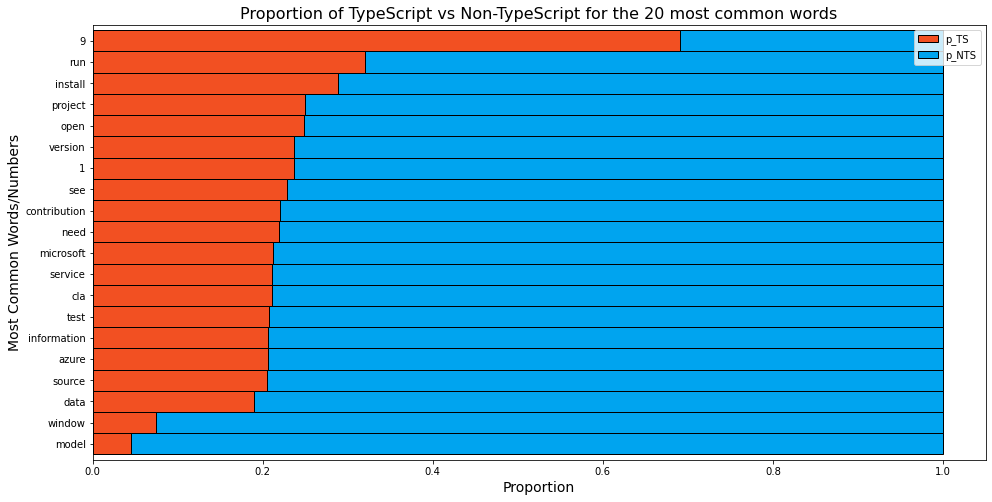

In [134]:
# figure out the percentage
(word_counts
 .assign(p_NTS=word_counts.NTS / word_counts['all'],
         p_TS=word_counts.TS / word_counts['all'])
 .sort_values(by='all')
 [['p_TS', 'p_NTS']]
 .tail(20)
 .sort_values('p_TS')
 .plot.barh(stacked=True, width = 1, ec = 'k', color=['#f25022', '#00a4ef'], figsize = (16, 8)))

plt.title('Proportion of TypeScript vs Non-TypeScript for the 20 most common words', fontsize=16)
plt.xlabel('Proportion', fontsize=14)
plt.ylabel('Most Common Words/Numbers', fontsize=14)
plt.show()

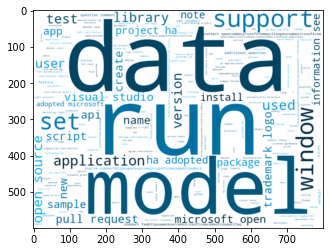

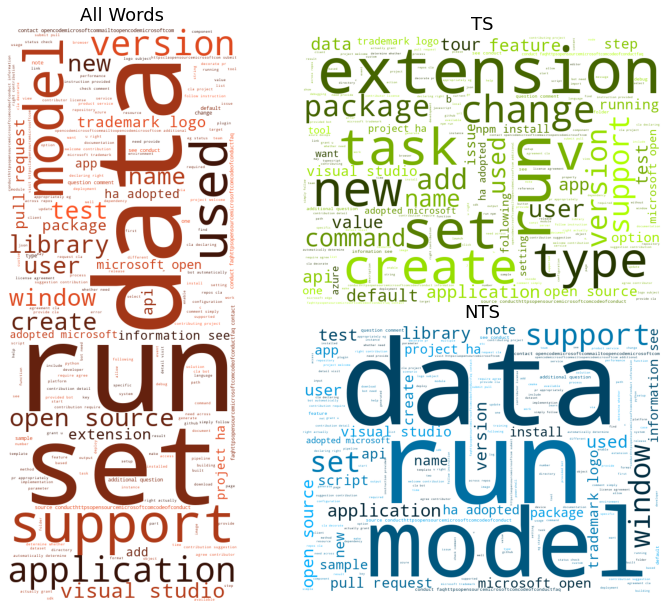

In [21]:
#Create Word Clouds 

color_func1 = get_single_color_func('#f25022')
color_func2 = get_single_color_func('#7fba00')
color_func3 = get_single_color_func('#00a4ef')

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
TS_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(TS_words))
NTS_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(NTS_words))


plt.imshow(all_cloud.recolor(color_func=color_func1, random_state=3),
           interpolation="bilinear")
plt.imshow(TS_cloud.recolor(color_func=color_func2, random_state=3),
           interpolation="bilinear")
plt.imshow(NTS_cloud.recolor(color_func=color_func3, random_state=3),
           interpolation="bilinear")

plt.figure(figsize=(10, 8))

axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(TS_cloud)
axs[2].imshow(NTS_cloud)

axs[0].set_title('All Words', fontsize=18)
axs[1].set_title('TS', fontsize=18)
axs[2].set_title('NTS', fontsize=18)

for ax in axs: ax.axis('off')
    
plt.show()

#### Visually, there is a difference in the top words found in TypeScript repos vs Non-TypeScript repos.

In [22]:
#Bi-grams: Top 20 for TypeScript words

top_20_TS_bigrams = (pd.Series(nltk.ngrams(TS_words, 2))
                      .value_counts()
                      .head(20))

top_20_TS_bigrams

(9, 9)                                                            159
(open, source)                                                    158
(visual, studio)                                                  154
(npm, install)                                                    145
(microsoft, open)                                                 142
(trademark, logo)                                                 139
(project, ha)                                                     130
(ha, adopted)                                                     130
(adopted, microsoft)                                              129
(information, see)                                                129
(source, conducthttpsopensourcemicrosoftcomcodeofconduct)         129
(question, comment)                                               127
(see, conduct)                                                    126
(additional, question)                                            126
(conduct, faqhttpsop

In [23]:
#Bi-grams: Top 20 for Non-TypeScript words

top_20_NTS_bigrams = (pd.Series(nltk.ngrams(NTS_words, 2))
                      .value_counts()
                      .head(20))

top_20_NTS_bigrams

(open, source)                                                    594
(pull, request)                                                   531
(trademark, logo)                                                 527
(visual, studio)                                                  518
(microsoft, open)                                                 487
(information, see)                                                444
(project, ha)                                                     441
(ha, adopted)                                                     437
(adopted, microsoft)                                              436
(source, conducthttpsopensourcemicrosoftcomcodeofconduct)         433
(question, comment)                                               433
(see, conduct)                                                    429
(additional, question)                                            429
(contact, opencodemicrosoftcommailtoopencodemicrosoftcom)         417
(opencodemicrosoftco

In [24]:
#Bi-grams: Top 20 for all words

top_20_all_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_all_bigrams

(open, source)                                                    752
(visual, studio)                                                  672
(trademark, logo)                                                 666
(pull, request)                                                   653
(microsoft, open)                                                 629
(information, see)                                                573
(project, ha)                                                     571
(ha, adopted)                                                     567
(adopted, microsoft)                                              565
(source, conducthttpsopensourcemicrosoftcomcodeofconduct)         562
(question, comment)                                               560
(additional, question)                                            555
(see, conduct)                                                    555
(contact, opencodemicrosoftcommailtoopencodemicrosoftcom)         540
(conduct, faqhttpsop

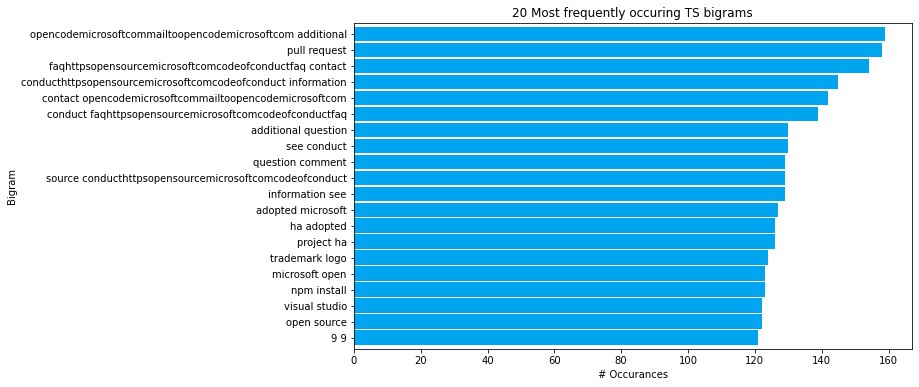

In [25]:
top_20_TS_bigrams.sort_values().plot.barh(color='#00a4ef', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring TS bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_TS_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

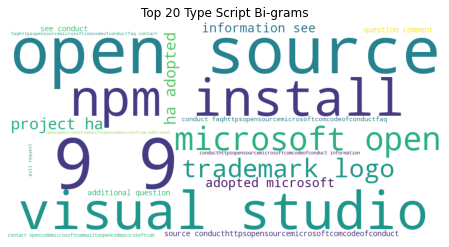

In [26]:
#Bigram Word Clouds

# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_TS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)

plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Type Script Bi-grams')
plt.show()

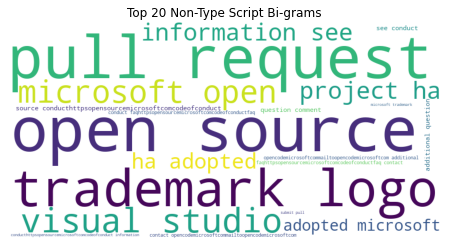

In [27]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_NTS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Non-Type Script Bi-grams')
plt.show()

### Q.) Does the length of the README vary by programming language?

In [28]:
train.groupby('language')['readme_char_count','clean_word_count'].mean().sort_values(by='clean_word_count')

,readme_char_count,clean_word_count
language,,
Dafny,206.000000,28.000000
PLpgSQL,883.000000,120.000000
TeX,1526.000000,207.000000
CodeQL,1885.000000,247.000000
F#,2067.333333,249.666667
Bicep,1823.000000,257.000000
VBScript,1956.000000,268.000000
SCSS,2463.000000,333.666667
R,2666.000000,355.000000


#### README lengths do seem to vary by programming language.
   - MATLAB repos are the largest READMEs and Dafny repos are the smallest.

### Q) What does the distribution of IDFs look like for the most common words?

In [29]:
train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True


In [30]:
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(train.lemma_no_stopwords)

In [31]:
pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names())

,00,000,0000,000000,00000000,00000000000000000000000000000000,0000000000000000000000000000000000000000,0000000000000000aaaaaaaaaaaaaaaa,000001,000001163jpg,...,zz,zza,zzc1v,zzgkuu5emjwgy,zzhifxzjtfwg6,zzt6iwiwzukzl8rfk,zztazwihbirjbdgrjzg,zzvn2m,zzvr0wx4bb1qgdhdqx2m2q9jqd9,zzxzzrivxr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
tfidf_lemma = pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()



In [33]:
tfidf_lemma.head()

microsoft      1.191716
see            1.193098
project        1.211242
information    1.236921
ha             1.248549
dtype: float64

In [34]:
tfidf_lemma.tail()

furtherdocstakeitfurthermd    7.08336
fusi                          7.08336
fuss                          7.08336
funded                        7.08336
zzxzzrivxr                    7.08336
dtype: float64

In [35]:
tfidf_lemma.max(), tfidf_lemma.min()

(7.083359811812238, 1.1917155999864666)

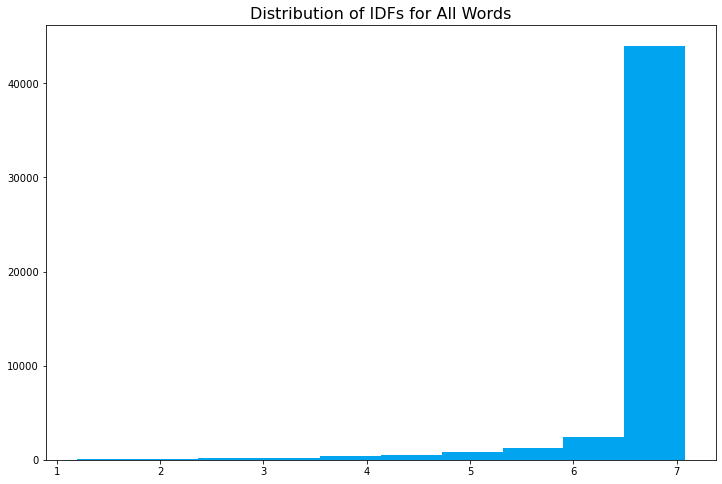

In [96]:
#Distribution of all IDFs
plt.figure(figsize=(12,8))
plt.hist(tfidf_lemma, color='#00a4ef')
plt.title("Distribution of IDFs for All Words", fontsize=16);

### Q) Does the message length matter in comparing repos by programming language?

In [37]:
train['message_length'] = train.lemma_no_stopwords.apply(len)

In [38]:
train['word_count'] =train.lemma_no_stopwords.apply(str.split).apply(len)

train.head()

,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript,message_length,word_count
153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False,877,90
560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False,5100,578
1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False,3747,442
1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False,1390,151
1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True,1552,169


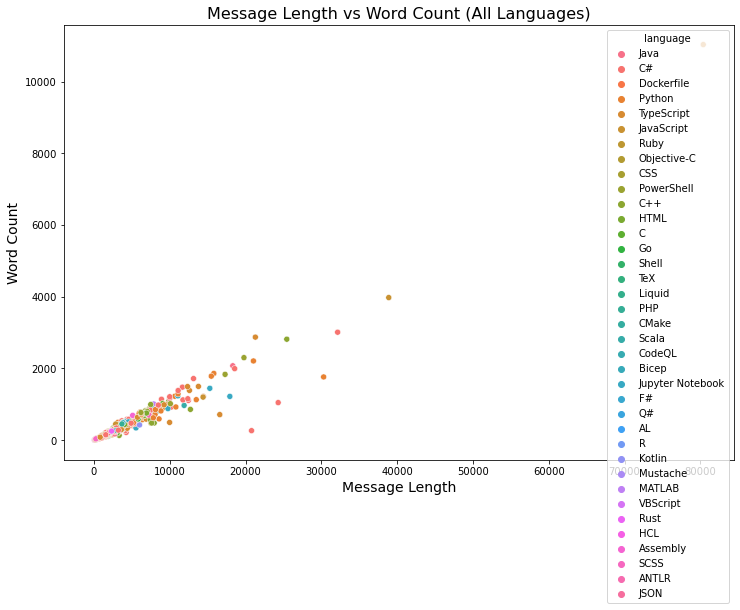

In [94]:
#Plot message length vs word count for all programming languages
plt.figure(figsize=(12,8))
sns.scatterplot(data = train.head(500), x = 'message_length', y = 'word_count', hue = 'language')
plt.title('Message Length vs Word Count (All Languages)', fontsize=16)
plt.xlabel('Message Length', fontsize=14)
plt.ylabel('Word Count', fontsize=14)
plt.show()

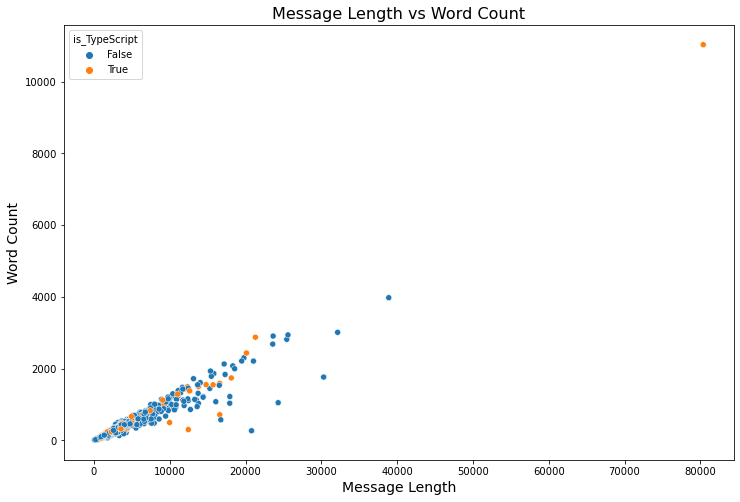

In [93]:
#Plot message length vs word count for Type Script vs Non-TypeScript
plt.figure(figsize=(12,8))
sns.scatterplot(data = train.head(5000), x = 'message_length', y = 'word_count', hue = 'is_TypeScript')
plt.title('Message Length vs Word Count', fontsize=16)
plt.xlabel('Message Length', fontsize=14)
plt.ylabel('Word Count', fontsize=14)
plt.show()

##### No clear pattern in message length for Type Script vs Non-TypeScript 

In [41]:
#Compare the mean and median message length between languages

train.groupby('language').message_length.agg(['mean', 'median'])

,mean,median
language,,
AL,2617.000000,2617.0
ANTLR,7261.000000,7261.0
Assembly,5107.000000,5107.0
Batchfile,3160.000000,3160.0
Bicep,1361.000000,1361.0
C,4218.937500,2533.5
C#,5049.061644,3008.0
C++,5061.285714,3673.5
CMake,8446.000000,8446.0


In [42]:
mean_med = train.groupby('is_TypeScript').message_length.agg(['mean', 'median'])

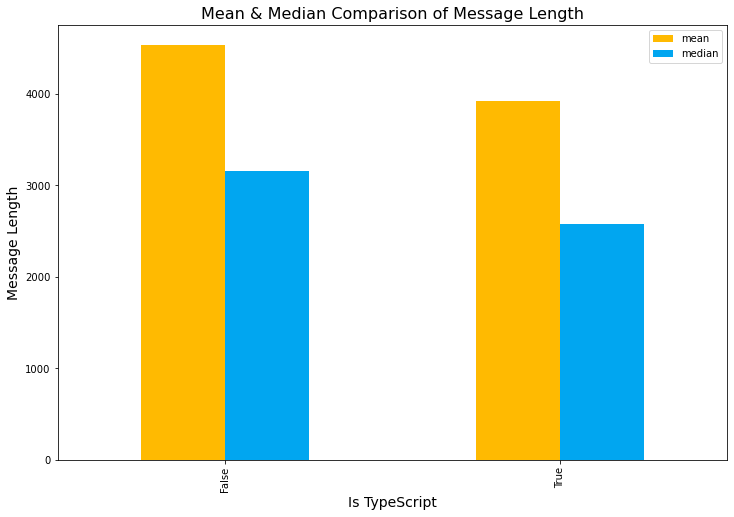

In [92]:
mean_med.plot(kind="bar", color=['#ffba01', '#01a6f0'], figsize=(12, 8))

plt.title('Mean & Median Comparison of Message Length', fontsize=16)
plt.xlabel('Is TypeScript', fontsize=14)
plt.ylabel('Message Length', fontsize=14)
plt.show()

#### The mean and median are lower for TypeScript message lengths compared to Non-TypeScript message lengths.

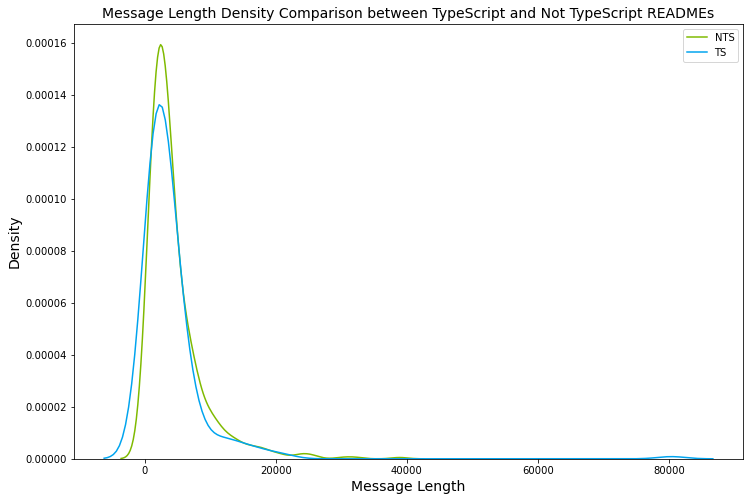

In [91]:
# check out the distributions
plt.figure(figsize=(12,8))
sns.kdeplot(train[train.is_TypeScript == False].message_length, label = 'NTS', color='#7fba00')
sns.kdeplot(train[train.is_TypeScript == True].message_length, label = 'TS', color='#00a4ef')
plt.legend()
plt.title('Message Length Density Comparison between TypeScript and Not TypeScript READMEs', fontsize=14)
plt.xlabel('Message Length', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

### Hypothesis

#### 1.) Is the message length independent of the programming language?

$H_0$: The mean message length for TypeScript is the same as the mean for all other programming languages.

$H_a$: The mean message length for TypeScript is not the same as the mean for all other programming languages.

In [45]:
alpha = 0.05

In [46]:
#Create boolean masks
is_TypeScript = train.language == 'TypeScript'

In [47]:
is_not_TypeScript = train.language != 'TypeScript'

In [48]:
t, p = stats.mannwhitneyu(train[is_TypeScript].message_length,train[is_not_TypeScript].message_length, alternative = 'two-sided' )

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 61702.000
p = 0.000


In [49]:
if p < alpha:
    print ("We reject the null hypothesis with 95% confidence.")
else:
    print ("We accept the null hypothesis because the results did not pass the 95% confidence level.")

We reject the null hypothesis with 95% confidence.


#### 2.) Does the word 'data' occur statistically more often in TypeScript documents than in other languages?

$H_0$: The word 'data' does not occur more often in non-TypeScript documents than in TypeScript.

$H_a$: The word 'data' does occur more often in non-TypeScript documents than in TypeScript.

In [50]:
alpha = 0.05

In [51]:
#Get the count of the word 'data' in content

data_count_list = []

for document in train.lemma_no_stopwords:
    
    word_list = str(document).split()
    
    i = 0
    
    for word in word_list:
        
        if word == 'data':
            i += 1

    data_count_list.append(i)
    
data_count_series = pd.Series(data_count_list)

train['preserve_index'] = train.index

train = train.reset_index()

train['data_word_counts'] = data_count_series

train.head()

,index,repo,language,clean,lemma_no_stopwords,clean_word_count,readme_char_count,is_TypeScript,message_length,word_count,preserve_index,data_word_counts
0,153,microsoft/AppCenter-Test-Appium-Java-Extensions,Java,appium java extensions this project provides e...,appium java extension project provides extensi...,157,1156,False,877,90,153,0
1,560,microsoft/PowerApps-Language-Tooling,C#,imagehttpsimgshieldsiogithubworkflowstatusmicr...,imagehttpsimgshieldsiogithubworkflowstatusmicr...,1019,6981,False,5100,578,560,1
2,1354,microsoft/vscode-remote-try-php,Dockerfile,try out development containers php\r \r a deve...,try development container php development cont...,783,5221,False,3747,442,1354,1
3,1158,microsoft/Dr-Jekyll-and-Mr-Hyde-The-Strange-Ca...,Python,project code for the neurips 2021 paper dr jek...,project neurips 2021 paper dr jekyll mr hyde s...,257,1831,False,1390,151,1158,0
4,1343,microsoft/ai.ed,TypeScript,aied this is the ai for programming education ...,aied ai programming education project goal pro...,311,2141,True,1552,169,1343,0


In [52]:
train.data_word_counts.unique()

array([ 0,  1,  3,  2, 58,  8, 33,  5,  4, 12,  6, 13, 14,  7, 18, 16, 36,
       22, 37, 11, 10, 21,  9, 24, 19, 23, 20, 74, 17, 42])

In [53]:
#Create boolean masks

is_TypeScript = train.language == 'TypeScript'
is_not_TypeScript = train.language != 'TypeScript'

In [54]:
t, p = stats.mannwhitneyu(train[is_TypeScript].data_word_counts,train[is_not_TypeScript].data_word_counts, alternative = 'less' )

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 65213.500
p = 0.003


In [55]:
if p < alpha:
    print ("We reject the null hypothesis with 95% confidence.")
else:
    print ("We accept the null hypothesis because the results did not pass the 95% confidence level.")

We reject the null hypothesis with 95% confidence.


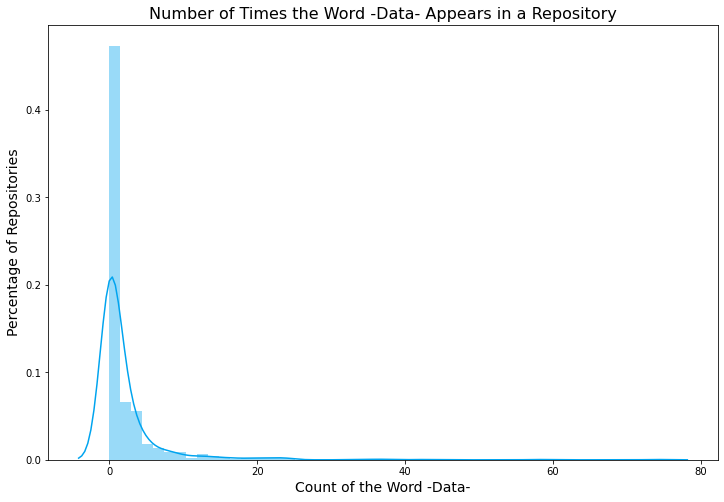

In [90]:
import seaborn as sns
plt.figure(figsize=(12,8))
#sns.distplot(train.word_count)
sns.distplot(train.data_word_counts , color='#00a4ef')
plt.xlabel("Count of the Word -Data-", fontsize=14)
plt.ylabel("Percentage of Repositories", fontsize=14)

plt.title("Number of Times the Word -Data- Appears in a Repository", fontsize=16)
plt.show()

##### It appears most repositories do not contain the word 'Data' or it appears less than 20 times

### Exploration Takeaways:
- TypeScript is the most common type of programming language used making up 25% of the the repos acquired. 
- We will make TypeScript the target programming language to predict.
- The most common words in READMEs for ALL repos are:

    - project      
    - microsoft    
    - run          
    - 9            
    - azure 

- The most common words in READMEs for TypeScript repos are:

    - 9            
    - project      
    - run          
    - microsoft    
    - extension  
    
- The most common words in READMEs for Non-TypeScript repos are:

    - project      
    - microsoft    
    - azure        
    - run          
    - data  
- README lengths do seem to vary by programming language.
   - MATLAB repos are the largest READMEs and Dafny repos are the smallest.
- IDFs range from 1.19 for the word 'microsoft' to 7.08 for several words
- The mean is  generally lower for TypeScript message lengths compared to Non-TypeScript message lengths.
- The mean message length is the not same all programming languages.
- The word 'data' does occur more often in non-TypeScript documents than in TypeScript.
- Most repositories do not contain the word 'Data' or it appears less than 20 times

## Modeling
First we will implement the classification models, then we will look at the results.

### Model Implementation
The goal of the modeling step is to create several classification models with different hyperparameter combinations to best-predict whether a README belongs to a TypeScript repository or not. The model creation, fit, and prediction is tied to one function in model.py, and the accuracy scores are tied to another function.

First, we **isolate the target** from the data by designating the README column as X for each split and the is_TypeScript column as y for each split.

In [57]:
X_train, y_train = train.lemma_no_stopwords, train.is_TypeScript
X_validate, y_validate = validate.lemma_no_stopwords, validate.is_TypeScript
X_test, y_test = test.lemma_no_stopwords, test.is_TypeScript

Next, we use our model.py function nlp_shotgun to **create and fit many classification models** on the data from train and validate splits, then append each models' **predictions** to a predictions dataframe. This function includes a baseline calculation.

In [58]:
y_train_preds, y_validate_preds = model.nlp_shotgun(X_train, y_train, 
                                                    X_validate, y_validate)

After, we use our model.py function print_nlp_results to **calculate accuracy scores** and print the results to a dataframe.

In [59]:
all_models = model.print_nlp_results(y_train_preds, y_validate_preds)\
.sort_values(by=['OutSample_Accuracy', 'InSample_Accuracy'], ascending=False)
all_models

,Model,InSample_Accuracy,OutSample_Accuracy
8,tfidf_tree_maxdepth5,0.904110,0.868182
6,tfidf_tree_maxdepth3,0.864155,0.859091
5,cv_tree_maxdepth3,0.843607,0.859091
3,cv_tree_maxdepth2,0.828767,0.859091
4,tfidf_tree_maxdepth2,0.831050,0.854545
7,cv_tree_maxdepth5,0.877854,0.850000
21,cv_logit,0.997717,0.845455
10,tfidf_tree_maxdepth10,0.958904,0.845455
1,cv_tree_maxdepth1,0.803653,0.845455
2,tfidf_tree_maxdepth1,0.803653,0.845455


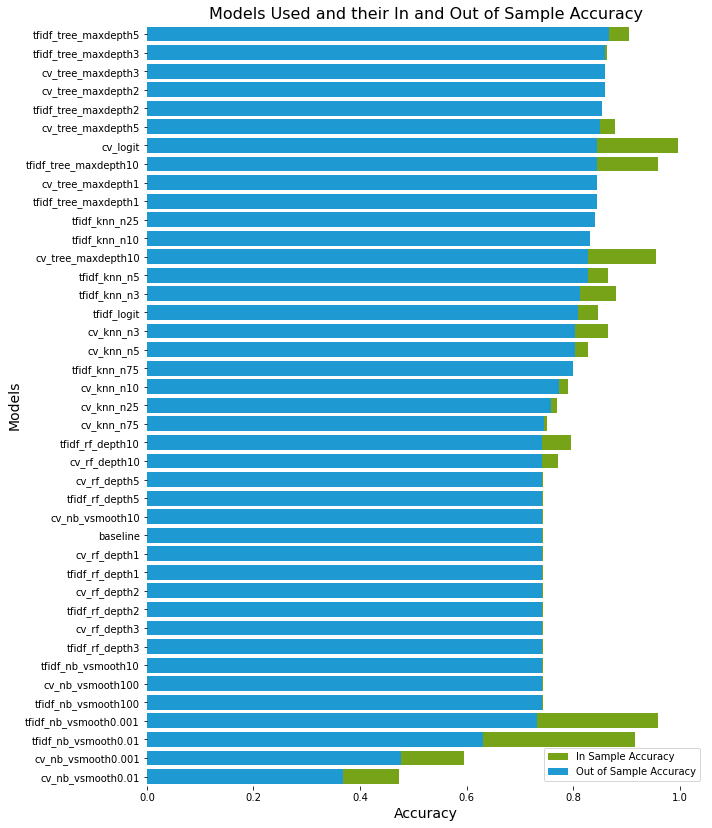

In [127]:
# Initialize the matplotlib figure
plt.figure(figsize=(10, 14))

# Plot of the Modeling Results on train
sns.barplot(x="InSample_Accuracy", y="Model", data=all_models, label="In Sample Accuracy", color='#7fba00')

# Plot of the Modeling Results on validate
sns.barplot(x="OutSample_Accuracy", y="Model", data=all_models, label="Out of Sample Accuracy", color='#00a4ef')

# Add a legend and informative axis label
plt.title('Models Used and their In and Out of Sample Accuracy', fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.legend()

sns.despine(left=True, bottom=True)

We now **select our best performing model**, the TFIDF-Vectorized DecisionTreeClassifier with max_depth=3 and random_state=123, to **predict on the test split**. In order to accomplish this, we manually create and fit the same model on the TFIDF-vectorized train split, then generate predictions on the TFIDF-vectorized test split and calculate the accuracy score.

In [61]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

tfidf_tree3 = DecisionTreeClassifier(max_depth=3, random_state=123)
tfidf_tree3.fit(X_train_tfidf, y_train)
test_predictions = tfidf_tree3.predict(X_test_tfidf)

baseline = round((y_test == False).mean(), 3)
accuracy = round((y_test == test_predictions).mean(), 3)
print('Baseline accuracy on test split:', baseline)
print('Model accuracy on test split:', accuracy)

Baseline accuracy on test split: 0.741
Model accuracy on test split: 0.81


### Model Results
1. The baseline model had an accuracy of **74%** on all splits.
2. Our best-performing model, TFIDF-Vectorized DecisionTreeClassifier with max_depth=3 and random_state=123, had the following accuracies:
    - In-Sample Split: **86%**
    - Out-of-Sample Split #1: **86%**
    - Out-Of-Sample Split #2: **81%**

Taking the average of the two out-of-sample splits, we assess that **our model can predict repository language using README contents with 84% accuracy.** Our model significantly outperforms the baseline for prediction accuracy.

In [113]:
top_model = all_models[all_models.Model == 'tfidf_tree_maxdepth3']
baseline = all_models[all_models.Model == 'baseline']

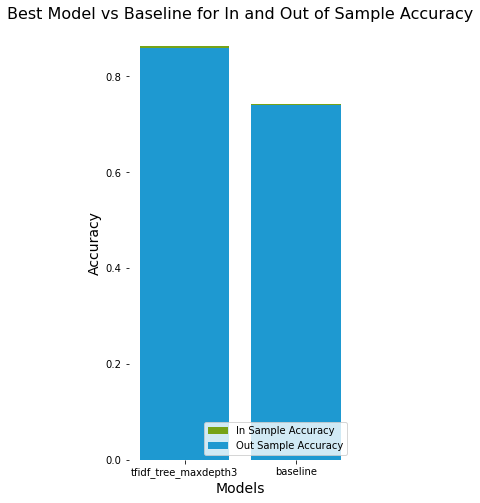

In [133]:
# Initialize the matplotlib figure
plt.figure(figsize=(4, 8))

# Plot of the Modeling Results on train
sns.barplot(x="Model", y="InSample_Accuracy", 
            data=all_models[(all_models.Model == 'baseline') | (all_models.Model == 'tfidf_tree_maxdepth3')], 
            label="In Sample Accuracy", color='#7fba00')
sns.barplot(x="Model", y="OutSample_Accuracy", 
            data=all_models[(all_models.Model == 'baseline') | (all_models.Model == 'tfidf_tree_maxdepth3')], 
            label="Out Sample Accuracy", color='#00a4ef')
# Plot of the Modeling Results on validate

# Add a legend and informative axis label
plt.title('Best Model vs Baseline for In and Out of Sample Accuracy', fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
#plt.legend()
plt.legend(loc = "lower right")
sns.despine(left=True, bottom=True)

# Conclusion
After acquiring and exploring the READMEs collected, we determined that the most common coding language in Microsoft's repos was TypeScript. Therefore, we decided to use classification modeling to attempt to predict whether the repos used TypeScript or not based on features from the READMEs. We were able to predict with an 84% accuracy whether a repo used TypeScript or not based on types of words and word length of a README.